In [1]:
#Universidad Nacional Autónoma de México
#Posgrado en Ciencias de la Tierra 
#Campo 1, geofísica de la Tierra sólida, sismología

#Elaborado por Isaac Valverde, 2023

#Programa 3: Notebook de python 3 que calcula los coeficientes de variación apartir de una simplificación de la estrategia semianalítica de Noquet (2018) que desprecia el término de asimetría en las marginales.
#Basado en la estrategia semianalítica de Noquet (2018)

#Nota: Las ecuaciones referidas en este notebook corresponden al articulo "Stochastic static fault slip inversion from geodetic data with non-negativity and bound constraints" Noquet (2018)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
#Función que calcula la media de una función de densidad normal truncada
#Entradas
#a: Límite inferior del intervalo de truncamiento
#b: Límite superior del intervalo de truncamiento
#m: Media de la normal truncada
#sd: Desviación estandar de la normal truncada
#ndx: Discretización del recorrido de la función
#Salida
#I: Media de la normal truncada

def TNmean(ai,bi,m,sd,ndx=10000):
    #Se define un vector de recorrido dentro del intervale de truncamiento 
    xi=np.linspace(ai,bi,ndx)
    #Se evalúa la función (normal truncada)
    fi=(norm.pdf((xi-m)/sd)/(norm.cdf((bi-m)/sd)-norm.cdf((ai-m)/sd)))*(1/sd)
    #Se obtiene la media a partir de la definición del primer momento de una función aleatoria
    I=np.trapz(fi*xi,x=xi,dx=(xi[1]-xi[0]))
    return I

In [4]:
#Función que calcula la varianza de una función de densidad normal truncada
#Entradas
#ai: Límite inferior del intervalo de truncamiento
#bi: Límite superior del intervalo de truncamiento
#m: Media de la normal truncada
#sd: Desviación estandar de la normal truncada
#ndx: Discretización del recorrido de la función
#Salida
#I: Varianza de la normal truncada

def TNvar(ai,bi,m,sd,ndx=10000):
    #Se define un vector de recorrido dentro del intervale de truncamiento
    xi=np.linspace(ai,bi,ndx)
    #Se evalúa la función (normal truncada)
    fi=(norm.pdf((xi-m)/sd)/(norm.cdf((bi-m)/sd)-norm.cdf((ai-m)/sd)))*(1/sd)
    #Se obtiene la varianza a partir de la definición del segundo momento de una función aleatoria
    I=np.trapz(fi*(xi-TNmean(ai,bi,m,sd,ndx))**2,x=xi,dx=(xi[1]-xi[0]))
    return I

In [5]:
#Funcion que calcula el vector de medias y la matriz de covarianza de la función de densidad de probabilidad posteriora partir de las expresiones de Tarantola y Valette (1982)
#Entradas
#G: Matriz kernel de la inversión (dimensión número de datos por número de parámetros) 
#d: Vector columna que contiene los datos de desplazamiento (de dimensión 1 por número de datos)
#Cdinv: Matriz de covarianza de los datos
#alpha:Valor de alpha para aproximar la distribución apriori
#limsup: Vector que contiene el límite superior del intervalo de truncamiento de cada parámetro
#m0: Media de la distribucion apriori
#Salida
#mv: Vector de medias de la posterior
#Cmv: Matriz de covarianza de la posterior

def mvCmv(G,d,Cdinv,alpha,limsup,m0):
    
    #Se obtiene el número de parámetros
    Nm=np.shape(G)[1]
    #Se obtiene la transpuesta de la kernel G
    GT=np.transpose(G)
    #Se define la desviación estandar (pp 373, primer párrafo, quinto renglón)
    sigma=alpha*(limsup/2)
    #Se define la matriz de covarianza de los parámetros (pp) (pp 372, primer parrafo, segundo renglón)
    #Cm=np.identity(Nm)*((sigma.reshape(Nm,1))**2)
    Cm=np.identity(Nm)*(((np.ones(Nm)*sigma).reshape(Nm,1))**2)
    #Se define la inversa la matriz de covarianza de los parámetros
    Cminv=np.linalg.inv(Cm)
    #Se define la matriz de covarianza posterior (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 7)
    Cmv=np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv)
    #Se define la transpuesta de la matriz de covarianza posterior
    CmvT=np.transpose(Cmv)
    #Se define la inversa de la matriz de covarianza posterior
    Cmvinv=np.matmul(np.matmul(GT,Cdinv),G)+Cminv
    #Se define la expectativa (Ecuaciones de Tarantola y Valette, pp. 369, Ec. 6)
    mv=np.matmul(np.linalg.inv(np.matmul(np.matmul(GT,Cdinv),G)+Cminv), np.matmul(np.matmul(GT,Cdinv),d)+np.matmul(Cminv,m0))
    return mv, Cmv

In [6]:
#Se define el número de datos (3 componentes por 11 estaciones)
Nd=33
#Se define el número de parámetros (Discretización de falla de 18x18)
Nm=324

In [7]:
#----------------------------Lectura y asignación de datos----------------------------

#Se extraen los datos de la matriz G
Gfile=open("G324.txt", "r")
Gstr=Gfile.read()
Gstrsplit=Gstr.split()

#Se extraen los datos de las estaciones
dfile=open("d.txt", "r")
dstr=dfile.read()
dstrsplit=dstr.split()

#Se define un arreglo para la matriz G
G=np.zeros((Nd,Nm))
#Se define un arreglo para los datos
d=np.zeros((Nd,1))

#Se almacenan los datos de la matriz G y el vector d en los arreglos correspondientes
for i in range (0,Nd):
    G[i,:]=np.array(Gstrsplit[(i*(Nm)):(i*(Nm))+Nm])
    d[i][0]=float(dstrsplit[i])
    
#Se define la transpuesta de la matriz G   
GT=np.transpose(G)

In [8]:
#----------------------------Matriz de covarianza de los datos----------------------------
#Se definen los valores de varianza de cada componente por estación
Vd=[2.1**2,2.5**2,5.1**2]*int(Nd/3)
#Se convierte le lista de valores a un arreglo numpy y las unidades a metros
Vd=np.array(Vd)*(10**-3)
#Se especifíca el vector de varianzas como vector columna
Vd=Vd.reshape(Nd,1)
#Se define una matriz cuya diagonal corresponde al vector de varianzas para obtener la matriz de covarianza de los datos
Cd=Vd*np.identity(Nd)
#Se obtiene la inversa de la matriz de covarianza de los datos
Cdinv=np.linalg.inv(Cd)

In [9]:
#------------------------Espacio de parámetros------------------------

#Se define el límite inferior de los parámetros
liminf=-0.004931
#Se define el límite superior de los parámetros
limsup=4.931506

#Se define un vector con el límite inferior de cada parámetro
a=np.zeros((1,Nm))+liminf
#Se define un vector con el límite superior de cada parámetro
b=np.zeros((1,Nm))+limsup
#Se define el valor de alpha
alpha=8
#Se define un vector con la media de los parámetros (pp 372, primer parrafo, tercer renglón)
m0=np.zeros((Nm,1))+(limsup/2)

In [10]:
#Se calcula el vector de medias y la matriz de covarianza de la posterior
mv_c,Cmv_c=mvCmv(G,d,Cdinv,alpha,limsup,m0)

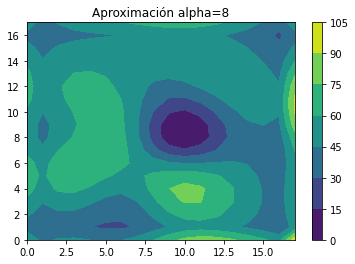

In [11]:
#Se definen arreglos para almacenar la media, desviación estandar y coeficiente de variación de las marginales
Means=np.zeros(Nm)
StandarD=np.zeros(Nm)
CV324=np.zeros(Nm)

#Se inicia un ciclo para recorrer todos los parámetros
for j in range(0,Nm):
    Means[j]=TNmean(liminf,limsup,mv_c[j],(Cmv_c[j][j])**(0.5))
    StandarD[j]=(TNvar(liminf,limsup,mv_c[j],(Cmv_c[j][j])**(0.5)))**(0.5)
    CV324[j]=(StandarD[j]/Means[j])*100

#Se desplazan los valores de coeficiente de variación a un rango iniciando en cero 0 
CV324=CV324-np.min(CV324)
#Se normalizan los coeficientes de variación respecto al valor máximo y se multiplican por 100 
CV324=(CV324*100)/np.max(CV324)
    
plt.contourf(np.rot90(CV324.reshape(18,18),k=3))
plt.title("Aproximación alpha="+str(alpha))
plt.colorbar()
plt.show()